In [84]:
import pandas as pd

#讀取時間為為周
def timeToWeek(data):
    # 將 Created 欄位轉換為日期格式
    data['Created'] = pd.to_datetime(data['Created'])
    
    # 建立每日項目創建數量的時間序列
    time_series = data['Created'].value_counts().sort_index()
    
    # 設置時間索引
    time_series.index = pd.DatetimeIndex(time_series.index)
    
    # 聚合數據為週
    weekly_series = time_series.resample('W').sum()

    return weekly_series

# 載入數據
file_path = './All The Bug Filter (Jira).csv'
data = pd.read_csv(file_path)
weekly_series = timeToWeek(data)

In [85]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

def detectTimeSeriesStable(time_series):
    stable = True
    
    # 檢測時間序列的平穩性
    result = adfuller(time_series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if(result[1] > 0.05):
        print("時間序列不穩定")
        stable = False
    
    
    # 繪製自相關和偏自相關圖
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(time_series.dropna(), ax=ax1)
    plot_pacf(time_series.dropna(), ax=ax2)
    plt.show()
    return stable

#如果時間序列不穩定要進行差分
finiteDifference = lambda time_series : time_series.diff().dropna()

In [96]:
from statsmodels.tsa.arima.model import ARIMA

def arima(time_series, p, d, q):
    # 檢測平穩性並擬合模型
    #result = adfuller(weekly_series)
    #print('ADF Statistic for weekly data: %f' % result[0])
    #print('p-value for weekly data: %f' % result[1])
    
    # 擬合 ARIMA 模型
    weekly_model = ARIMA(time_series, order=(p, d, q))
    weekly_model_fit = weekly_model.fit()
    
    # 顯示模型摘要
    print(weekly_model_fit.summary())
    return weekly_model_fit

# 進行未來預測
def forecast(time_model):
    weekly_forecast = time_model.forecast(steps=20)
    return weekly_forecast

ADF Statistic: -0.764603
p-value: 0.829299
時間序列不穩定


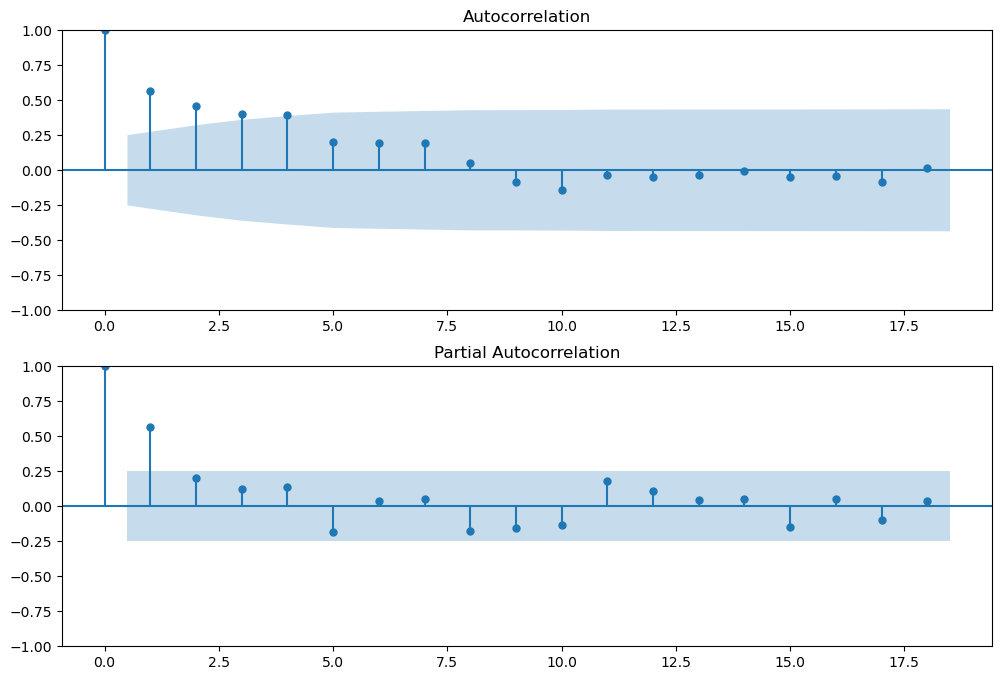

ADF Statistic: -3.067505
p-value: 0.029053


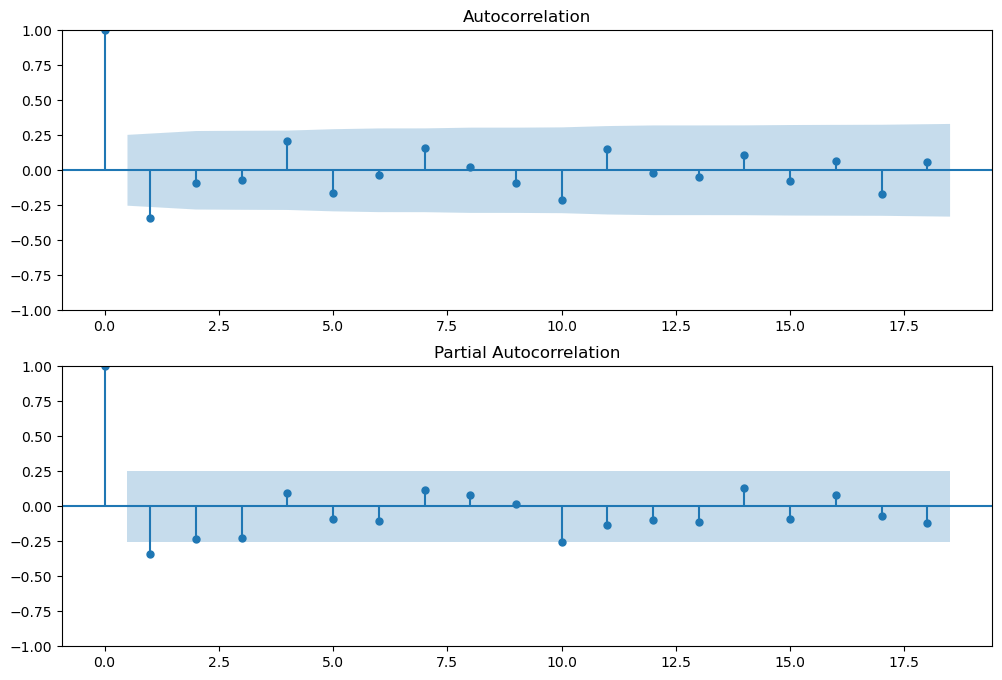

In [87]:
#使用Bug的資料集
#檢查時間序列穩定性
if not detectTimeSeriesStable(weekly_series):
    oneWay_weekly_series = finiteDifference(weekly_series)
    detectTimeSeriesStable(oneWay_weekly_series)

In [36]:
#使用Bug的資料集
myModel = arima(oneWay_weekly_series, 2, 1, 2)

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   60
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -212.995
Date:                Fri, 03 May 2024   AIC                            435.990
Time:                        06:17:46   BIC                            446.377
Sample:                    03-19-2023   HQIC                           440.045
                         - 05-05-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2388      0.454     -0.526      0.599      -1.128       0.651
ar.L2         -0.2573      0.258     -0.998      0.318      -0.762       0.248
ma.L1         -1.4193     14.448     -0.098      0.9

In [82]:
#使用Bug的資料集
weekly_forecast = forecast(myModel)
print("Weekly forecasted values:", weekly_forecast)

import numpy as np
# 计算反差分值
forecast_original = np.cumsum(weekly_forecast) + weekly_series[-1]

# 打印反差分后的预测值
print(forecast_original)

Weekly forecasted values: 2024-05-12    21.228384
2024-05-19     3.823719
2024-05-26    -5.713803
2024-06-02     1.041944
2024-06-09     1.882194
Freq: W-SUN, Name: predicted_mean, dtype: float64
2024-05-12    36.228384
2024-05-19    40.052104
2024-05-26    34.338300
2024-06-02    35.380244
2024-06-09    37.262438
Freq: W-SUN, Name: predicted_mean, dtype: float64


/tmp/ipykernel_4085455/3569869041.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_original = np.cumsum(weekly_forecast) + weekly_series[-1]


ADF Statistic: -0.764603
p-value: 0.829299
時間序列不穩定


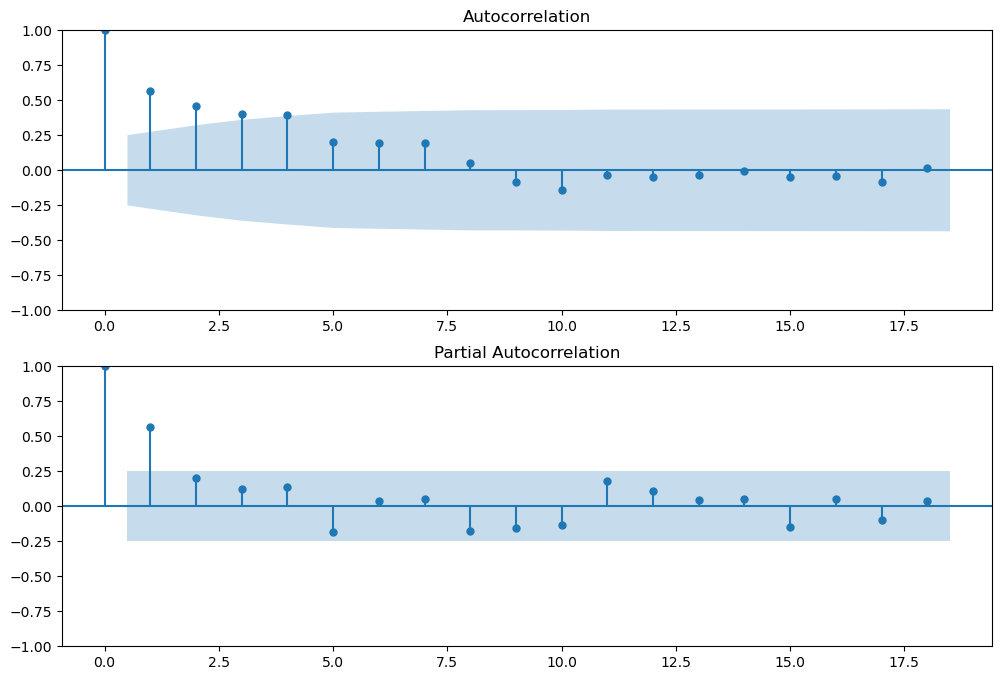

ADF Statistic: -3.067505
p-value: 0.029053


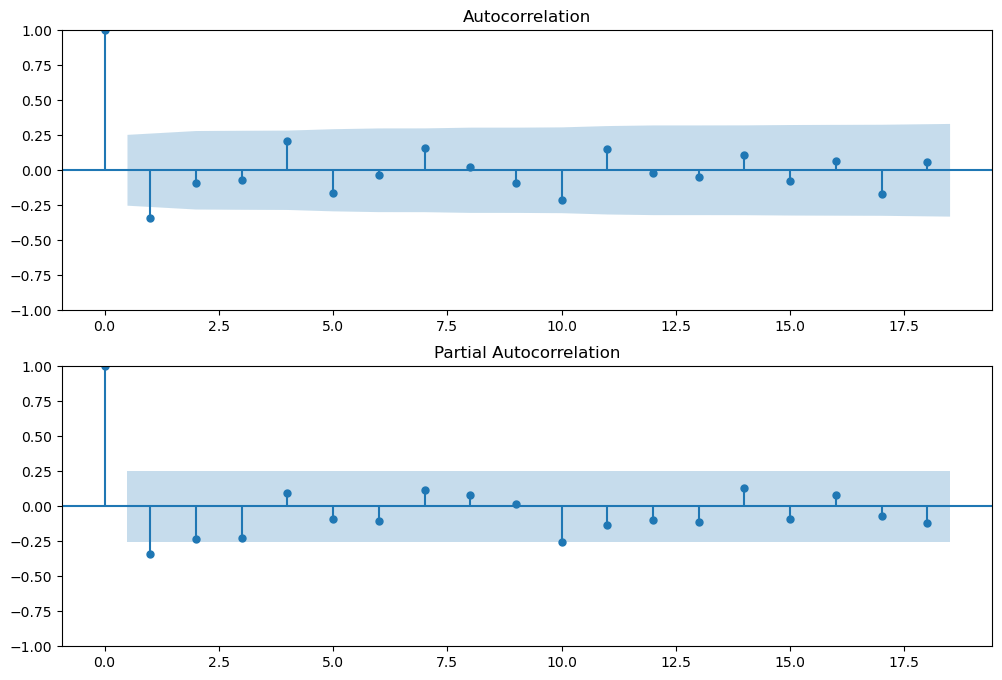

In [91]:
#使用專案的資料集
# Load data from the CSV file
work_file_path = './All The Develop Work (Jira).csv'
work_data = pd.read_csv(work_file_path)

work_weekly_series = timeToWeek(data)
if not detectTimeSeriesStable(work_weekly_series):
    oneWay_work_weekly_series = finiteDifference(work_weekly_series)
    detectTimeSeriesStable(oneWay_work_weekly_series)

In [92]:
workModel = arima(oneWay_work_weekly_series, 1, 1, 1)
work_weekly_forecast = forecast(workModel)
print("Weekly forecasted values:", work_weekly_forecast)

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -217.470
Date:                Mon, 06 May 2024   AIC                            440.941
Time:                        01:15:33   BIC                            447.174
Sample:                    03-19-2023   HQIC                           443.374
                         - 05-05-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4126      0.140     -2.948      0.003      -0.687      -0.138
ma.L1         -0.9994      5.064     -0.197      0.844     -10.925       8.926
sigma2        85.6596    441.047      0.194      0.8

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [98]:
import numpy as np
print("========== 專案 數量=============")
weekly_forecast = forecast(workModel)
# 计算反差分值
forecast_original = np.cumsum(weekly_forecast) + weekly_series[-1]
# 打印反差分后的预测值
print(forecast_original)

print("========== Bug 數量=============")
#使用Bug的資料集
weekly_forecast = forecast(myModel)
# 计算反差分值
forecast_original = np.cumsum(weekly_forecast) + weekly_series[-1]
# 打印反差分后的预测值
print(forecast_original)

========== 專案 數量=============
2024-05-12    28.616013
2024-05-19    23.411458
2024-05-26    25.972022
2024-06-02    25.328800
2024-06-09    26.007419
2024-06-16    26.140663
2024-06-23    26.498921
2024-06-30    26.764342
2024-07-07    27.068066
2024-07-14    27.355987
2024-07-21    27.650428
2024-07-28    27.942179
2024-08-04    28.235039
2024-08-11    28.527442
2024-08-18    28.820034
2024-08-25    29.112548
2024-09-01    29.405094
2024-09-08    29.697626
2024-09-15    29.990165
2024-09-22    30.282700
Freq: W-SUN, Name: predicted_mean, dtype: float64
========== Bug 數量=============
2024-05-12    36.228384
2024-05-19    40.052104
2024-05-26    34.338300
2024-06-02    35.380244
2024-06-09    37.262438
2024-06-16    37.205850
2024-06-23    37.396142
2024-06-30    38.026272
2024-07-07    38.487836
2024-07-14    38.876500
2024-07-21    39.325943
2024-07-28    39.779625
2024-08-04    40.216658
2024-08-11    40.656577
2024-08-18    41.100090
2024-08-25    41.542002
2024-09-01    41.983371
2

/tmp/ipykernel_4085455/3424629102.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_original = np.cumsum(weekly_forecast) + weekly_series[-1]
/tmp/ipykernel_4085455/3424629102.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_original = np.cumsum(weekly_forecast) + weekly_series[-1]


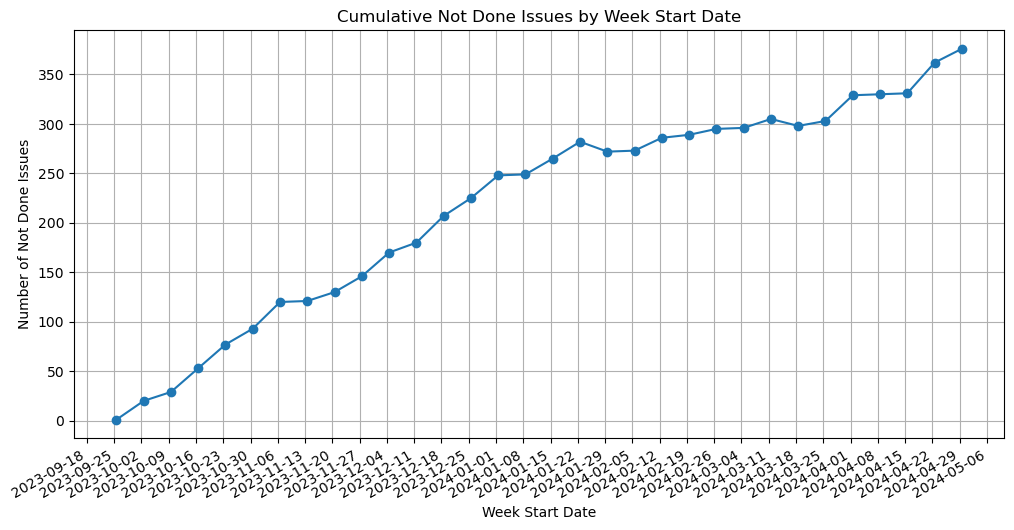

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data from the CSV file
file_path = './All The Develop Work (Jira).csv'
data = pd.read_csv(file_path)

# Convert 'Created' and 'Updated' columns to datetime type
data['Created'] = pd.to_datetime(data['Created'], format='%Y/%m/%d %H:%M')
data['Updated'] = pd.to_datetime(data['Updated'], format='%Y/%m/%d %H:%M')

# Set week number based on 'Created' date
data['Week_Start_Date'] = data['Created'] - pd.to_timedelta(data['Created'].dt.weekday, unit='d')

# Determine the range of weeks in the dataset
min_date = data['Week_Start_Date'].min()
max_date = data['Week_Start_Date'].max() + pd.DateOffset(days=6)

# Initialize a list to store cumulative counts of not done issues per week
week_dates = pd.date_range(start=min_date, end=max_date, freq='W-MON')
cumulative_not_done_counts = []

# Compute cumulative not done counts
for week_start in week_dates:
    ongoing_issues = data[(data['Week_Start_Date'] <= week_start) &
                          ((data['Status'] != 'Done') | (data['Updated'] > week_start + pd.DateOffset(days=6)))]
    count_not_done = len(ongoing_issues)
    cumulative_not_done_counts.append(count_not_done)

# Plotting the data
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(week_dates, cumulative_not_done_counts, marker='o', linestyle='-')
plt.title('Cumulative Not Done Issues by Week Start Date')
plt.xlabel('Week Start Date')
plt.ylabel('Number of Not Done Issues')
plt.grid(True)

# Format the x-axis to show dates more clearly
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels to fit them better

plt.savefig("show.png")
plt.show()